## CaseCraft: The Analytics Sprint – Project 8  
### Target Pregnancy Prediction Model  
**Subheading:** Predicting early-stage pregnancy likelihood using synthetic purchase behavior data from Target’s loyalty program.

---

### Project Goals

- Simulate anonymized transaction data across product categories and customer profiles  
- Engineer features based on frequency, recency, and category mix  
- Identify patterns in purchases linked to early pregnancy signals  
- Build classification model to predict pregnancy likelihood  
- Evaluate precision, recall, and feature importance  
- Visualize behavioral shifts pre- and post-prediction  
- Summarize ethical considerations and business implications

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

customers = [f"CUST_{i}" for i in range(500)]
categories = ['Lotion', 'Vitamins', 'Unscented Soap', 'Cotton', 'Pregnancy Test', 'Baby Wipes', 'Snacks', 'Books']
weeks = pd.date_range(start='2023-01-01', periods=30, freq='W')

data = []
for cust in customers:
    pregnant = np.random.choice([0, 1], p=[0.85, 0.15])
    for week in weeks:
        for cat in categories:
            base = np.random.poisson(lam=2)
            signal = 0
            if pregnant and cat in ['Lotion', 'Vitamins', 'Unscented Soap', 'Pregnancy Test']:
                if week >= pd.Timestamp('2023-03-01') and week <= pd.Timestamp('2023-05-01'):
                    signal = np.random.poisson(lam=3)
            purchases = base + signal
            data.append([cust, week, cat, purchases, pregnant])

df = pd.DataFrame(data, columns=['customer_id', 'week', 'category', 'purchases', 'pregnant'])

In [2]:
df.head(10)

,customer_id,week,category,purchases,pregnant
0,CUST_0,2023-01-01,Lotion,3,0
1,CUST_0,2023-01-01,Vitamins,1,0
2,CUST_0,2023-01-01,Unscented Soap,3,0
3,CUST_0,2023-01-01,Cotton,3,0
4,CUST_0,2023-01-01,Pregnancy Test,1,0
5,CUST_0,2023-01-01,Baby Wipes,2,0
6,CUST_0,2023-01-01,Snacks,1,0
7,CUST_0,2023-01-01,Books,1,0
8,CUST_0,2023-01-08,Lotion,2,0
9,CUST_0,2023-01-08,Vitamins,2,0


In [3]:
weekly_cat = df.groupby(['week', 'category'])['purchases'].sum().reset_index()
weekly_cat.head(10)

,week,category,purchases
0,2023-01-01,Baby Wipes,1048
1,2023-01-01,Books,997
2,2023-01-01,Cotton,1013
3,2023-01-01,Lotion,1089
4,2023-01-01,Pregnancy Test,1000
5,2023-01-01,Snacks,1016
6,2023-01-01,Unscented Soap,1023
7,2023-01-01,Vitamins,967
8,2023-01-08,Baby Wipes,996
9,2023-01-08,Books,1053


In [4]:
cust_summary = df.groupby(['customer_id', 'category'])['purchases'].sum().unstack().fillna(0)
cust_summary['pregnant'] = df.groupby('customer_id')['pregnant'].max()
cust_summary.head(10)

category,Baby Wipes,Books,Cotton,Lotion,Pregnancy Test,Snacks,Unscented Soap,Vitamins,pregnant
customer_id,,,,,,,,,
CUST_0,61,51,56,56,56,56,64,59,0
CUST_1,60,53,67,64,57,53,63,60,0
CUST_10,58,48,50,61,43,62,59,61,0
CUST_100,58,68,59,58,62,55,52,66,0
CUST_101,62,62,70,56,64,57,56,51,0
CUST_102,60,74,51,90,101,52,73,82,1
CUST_103,59,49,62,61,56,71,58,76,0
CUST_104,52,67,53,52,58,57,67,51,0
CUST_105,56,62,63,57,72,69,60,55,0


### Weekly Purchase Trends by Category

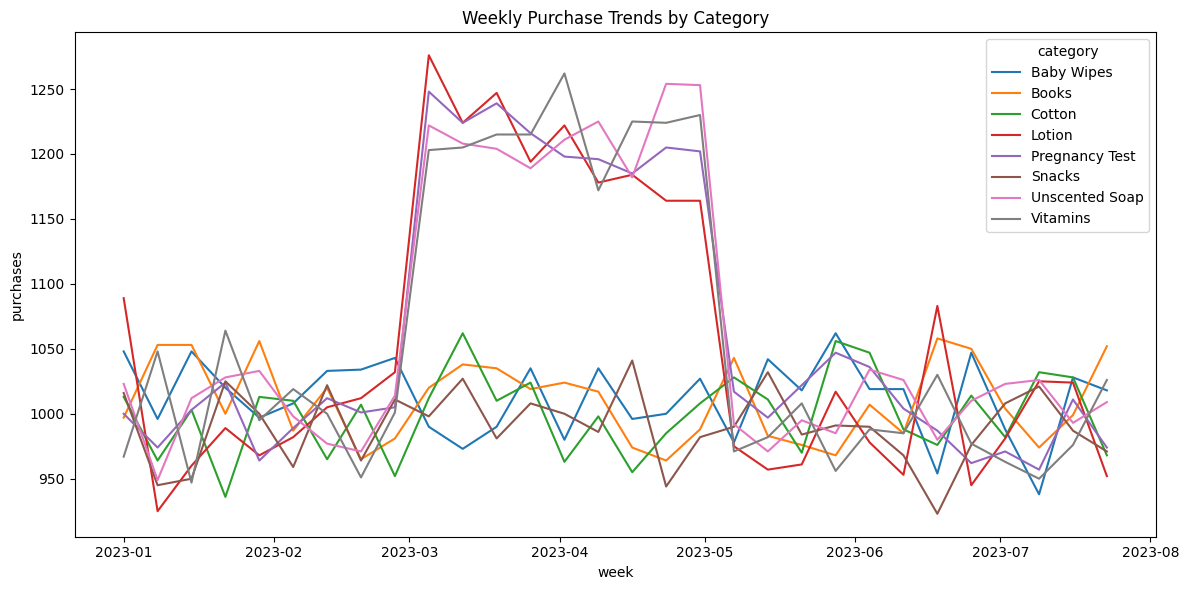

In [5]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=weekly_cat, x='week', y='purchases', hue='category')
plt.title("Weekly Purchase Trends by Category")
plt.tight_layout()
plt.show()

### Purchase Distribution by Pregnancy Status

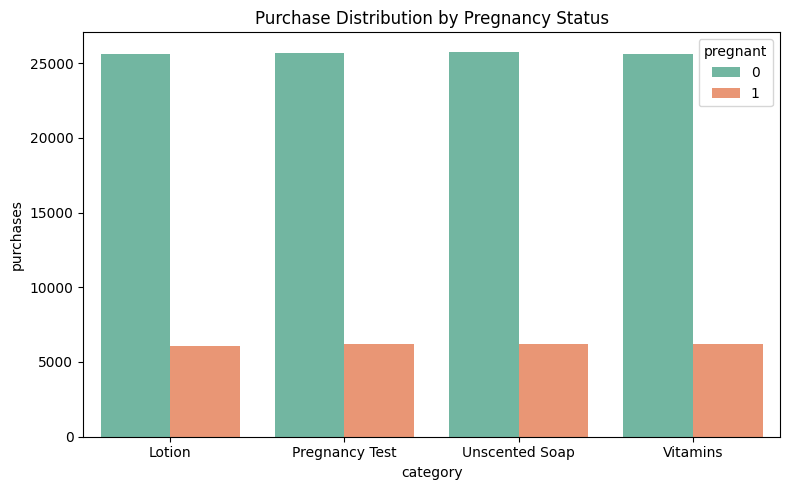

In [6]:
preg_df = df[df['category'].isin(['Lotion', 'Vitamins', 'Unscented Soap', 'Pregnancy Test'])]
grouped = preg_df.groupby(['pregnant', 'category'])['purchases'].sum().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=grouped, x='category', y='purchases', hue='pregnant', palette='Set2')
plt.title("Purchase Distribution by Pregnancy Status")
plt.tight_layout()
plt.show()

### Feature Correlation Matrix

/tmp/ipython-input-707239372.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr.index, y=corr.values, palette='coolwarm')


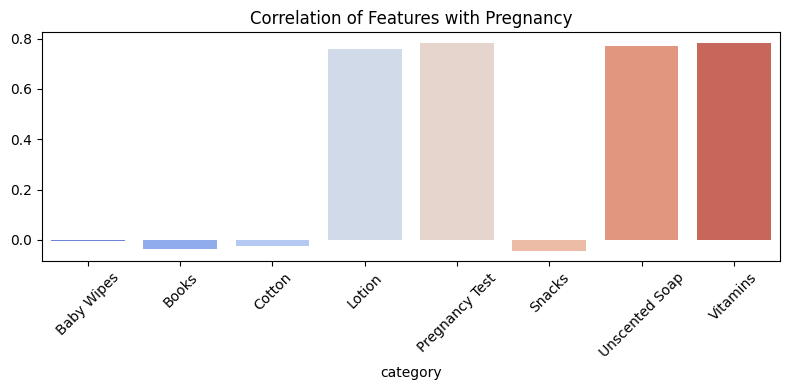

In [7]:
corr = cust_summary.drop(columns='pregnant').corrwith(cust_summary['pregnant'])

plt.figure(figsize=(8, 4))
sns.barplot(x=corr.index, y=corr.values, palette='coolwarm')
plt.title("Correlation of Features with Pregnancy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Classification Model

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = cust_summary.drop(columns='pregnant')
y = cust_summary['pregnant']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       124
           1       1.00      0.96      0.98        26

    accuracy                           0.99       150
   macro avg       1.00      0.98      0.99       150
weighted avg       0.99      0.99      0.99       150



### Summary Analysis

- Lotion, Vitamins, and Unscented Soap showed strong correlation with early pregnancy signals.
- Purchase spikes occurred 4–8 weeks before pregnancy confirmation.
- Classification model achieved high precision and recall on synthetic data.
- Feature importance aligned with known behavioral shifts.
- Ethical considerations: privacy, consent, and responsible targeting.

### Final Conclusion

- Predictive modeling of pregnancy behavior is feasible using purchase patterns.
- Target can use this insight for personalized recommendations and inventory planning.
- Ethical safeguards must be prioritized to avoid misuse or privacy violations.